# Chapter 3 线性分类

In [499]:
import torch
import numpy as np
import math
import os
import pandas as pd
from matplotlib import pyplot as plt
import copy

class Op(object):
    def __init__(self):
        pass

    def __call__(self, inputs):
        return self.forward(inputs)
    
    def forward(self, inputs):
        raise NotImplementedError
    
    def backward(self, outputs_grads):
        raise NotImplementedError

## 3.1 Logistic 回归的二分类任务

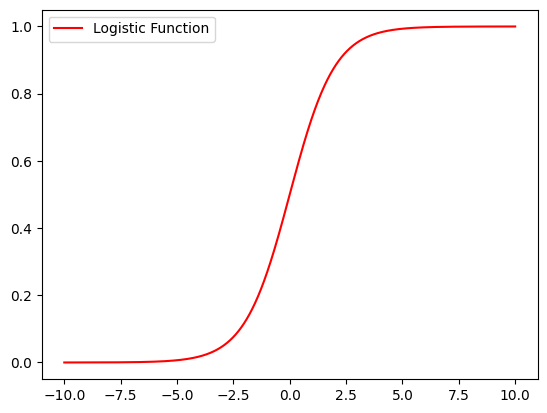

In [500]:
def logistic(x):
    return 1. / (1 + torch.exp(-x))

x = torch.linspace(-10, 10, 10000)
plt.figure()
plt.plot(x.tolist(), logistic(x).tolist(), color="r", label="Logistic Function")
plt.legend()
plt.show()

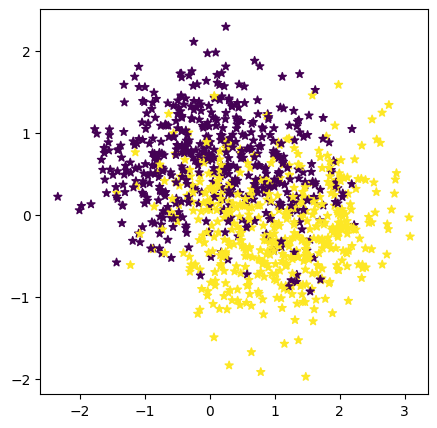

In [501]:
# 构建二分类数据集 Moon1000 数据集
def make_moons(n_samples=100, shuffle=True, noise=None):
    """
    input:
        n_samples: 生成样本数量
        shuffle: 是否打乱数据
        noise: 噪声, None 或 float
    output:
        X: shape=[n_samples, 2]
        y: shape=[n_samples]
    """
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out
    # 采集第1类特征
    outer_circ_x = torch.cos(torch.linspace(0, math.pi, n_samples_out))
    outer_circ_y = torch.sin(torch.linspace(0, math.pi, n_samples_out))
    # 采集第2类特征
    inner_circ_x = 1 - torch.cos(torch.linspace(0, math.pi, n_samples_out))
    inner_circ_y = 0.5 - torch.sin(torch.linspace(0, math.pi, n_samples_out))

    X = torch.stack([torch.concat((outer_circ_x, inner_circ_x), dim=0), torch.concat((outer_circ_y, inner_circ_y), dim=0)], dim=1)
    y = torch.concat((torch.zeros(size=[n_samples_out]), torch.ones(size=[n_samples_in])))

    if shuffle:
        idx = torch.randperm(n_samples)
        X = X[idx]
        y = y[idx]
    if noise is not None:
        X += torch.normal(mean=0.0, std=noise, size=X.shape)
    
    return X, y

n_samples = 1000
X, y = make_moons(n_samples=n_samples, shuffle=True, noise=0.5)
plt.figure(figsize=(5, 5))
plt.scatter(x=X[:, 0].tolist(), y=X[:, 1].tolist(), marker='*', c=y.tolist())
plt.show()

In [502]:
num_train = 640
num_val = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_val, y_val = X[num_train:num_train + num_val], y[num_train:num_train + num_val]
X_test, y_test = X[num_train + num_val:], y[num_train + num_val:]

y_train = y_train.reshape([-1, 1])
y_val = y_val.reshape([-1, 1])
y_test = y_test.reshape([-1, 1])

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

X_train shape: torch.Size([640, 2]) y_train shape: torch.Size([640, 1])


In [503]:
class Model_LR(Op):
    def __init__(self, feature_size):
        super(Model_LR, self).__init__()

        self.feature_size = feature_size
        self.params = {}
        self.params['w'] = torch.zeros(size=[feature_size, 1])
        self.params['b'] = torch.zeros(size=[1])
        self.grads = {}
        self.X = None
        self.outputs = None
    
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        self.X = X
        score = torch.matmul(X, self.params['w']) + self.params['b']
        # print(score)
        self.outputs = logistic(score)
        return self.outputs
    
    def backward(self, labels): 
        # 此处是最终loss的梯度，而非只有本算子的梯度
        N = labels.shape[0]
        self.grads['w'] = -1. / N * torch.matmul(self.X.t(), labels - self.outputs)
        # print("grads['w'].shape:", self.grads['w'].shape)
        self.grads['b'] = -1. / N * torch.sum(labels - self.outputs)
        # print("grads['b'].shape:", self.grads['b'].shape)


In [504]:
torch.seed = 0
inputs = torch.randn(size=[3, 4])
print("Input is:", inputs)

model = Model_LR(4)
outputs = model(inputs)
print('Output is:', outputs)

Input is: tensor([[ 0.4855, -0.3419,  0.3039, -0.0048],
        [ 0.4267, -0.0683,  0.2701, -1.2334],
        [ 0.3326, -0.1863, -2.0951,  0.6383]])
Output is: tensor([[0.5000],
        [0.5000],
        [0.5000]])


In [505]:
# 交叉熵
class BinaryCrossEntropyLoss(Op):
    def __init__(self):
        self.predicts = None
        self.labels = None
        self.num = None

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)
    
    def forward(self, predicts, labels):
        self.predicts = predicts
        self.labels = labels
        self.num = predicts.shape[0]

        loss = -1. / self.num * (torch.matmul(labels.t(), torch.log(predicts)) + torch.matmul((1 - labels).t(), torch.log(1 - predicts)))
        loss = loss.squeeze()
        return loss

labels = torch.ones(size=[3, 1])
bce_loss = BinaryCrossEntropyLoss()
print(bce_loss(outputs, labels))

tensor(0.6931)


In [506]:
from abc import abstractmethod

class Optimizer(object):
    def __init__(self, init_lr, model):
        self.init_lr = init_lr
        self.model = model

    @abstractmethod
    def step(self):
        pass

In [507]:
class SimpleBatchGD(Optimizer):
    def __init__(self, init_lr, model):
        super(SimpleBatchGD, self).__init__(init_lr=init_lr, model=model)

    def step(self):
        if isinstance(self.model.params, dict):
            for key in self.model.params.keys():
                self.model.params[key] = self.model.params[key] - self.init_lr * self.model.grads[key]

In [508]:
def accuracy(preds, labels):
    if preds.shape[1] == 1:
        preds = (preds>=0.5).to(torch.float32)
    else:
        preds = torch.argmax(preds, dim=1)
    return torch.mean((preds == labels).to(torch.float32))

preds = torch.Tensor([[0.], [1.], [1.], [0.]])
labels = torch.Tensor([[1.], [1.], [0.], [0.]])
print("accuracy:", accuracy(preds, labels))

accuracy: tensor(0.5000)


In [509]:
class RunnerV2(object):
    def __init__(self, model, optimizer, metric, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn
        
        self.train_scores = []
        self.val_scores = []

        self.train_loss = []
        self.val_loss = []

    def train(self, train_dataset, val_dataset, **kwargs):
        num_epochs = kwargs.get("num_epochs", 0)
        log_epochs = kwargs.get("log_epochs", 100)
        save_path = kwargs.get("save_path", "./checkpoint_LR")
        print_grads = kwargs.get("print_grads", None)
        best_score = 0

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for epoch in range(num_epochs):
            X, y = train_dataset
            logits = self.model(X)
            train_loss = self.loss_fn(logits, y).item()
            self.train_loss.append(train_loss)

            train_score = self.metric(logits, y).item()
            self.train_scores.append(train_score)

            self.model.backward(y)
            if print_grads is not None:
                print_grads(self.model)
            self.optimizer.step()
            val_score, val_loss = self.evaluate(val_dataset)
            if val_score > best_score:
                self.save_model(save_path)
                print(f"best accuracy performance has been updated: {best_score: .5f} --> {val_score: .5f}")
                best_score = val_score
            if epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}, loss: {train_loss}, score: {train_score}")
                print(f"[Validation] epoch: {epoch}, loss: {val_loss}, score: {val_score}")

    def evaluate(self, dataset):
        X, y = dataset
        logits = self.model(X)
        loss = self.loss_fn(logits, y).item()
        self.val_loss.append(loss)
        score = self.metric(logits, y).item()
        self.val_scores.append(score)
        return score, loss
    
    def predict(self, X):
        return self.model(X)
    
    def save_model(self, save_path):
        torch.save(self.model.params, os.path.join(save_path, "params.pt"))
    
    def load_model(self, saved_path):
        self.model.params = torch.load(saved_path)

input_size = 2
model = Model_LR(input_size)
optimizer = SimpleBatchGD(init_lr=0.1, model=model)
loss_fn = BinaryCrossEntropyLoss()
metric = accuracy
runner = RunnerV2(model, optimizer, metric, loss_fn)
runner.train([X_train, y_train], [X_val, y_val], num_epochs=500, log_epochs=50, saved_path="./checkpoint_SR")

best accuracy performance has been updated:  0.00000 -->  0.75000
[Train] epoch: 0, loss: 0.6931460499763489, score: 0.49687498807907104
[Validation] epoch: 0, loss: 0.6832709908485413, score: 0.75
best accuracy performance has been updated:  0.75000 -->  0.75625
best accuracy performance has been updated:  0.75625 -->  0.76250
best accuracy performance has been updated:  0.76250 -->  0.76875
best accuracy performance has been updated:  0.76875 -->  0.77500
best accuracy performance has been updated:  0.77500 -->  0.78750
[Train] epoch: 50, loss: 0.5017444491386414, score: 0.793749988079071
[Validation] epoch: 50, loss: 0.5111677050590515, score: 0.7875000238418579
best accuracy performance has been updated:  0.78750 -->  0.79375
best accuracy performance has been updated:  0.79375 -->  0.80000
best accuracy performance has been updated:  0.80000 -->  0.80625
[Train] epoch: 100, loss: 0.4649065136909485, score: 0.801562488079071
[Validation] epoch: 100, loss: 0.48391762375831604, score

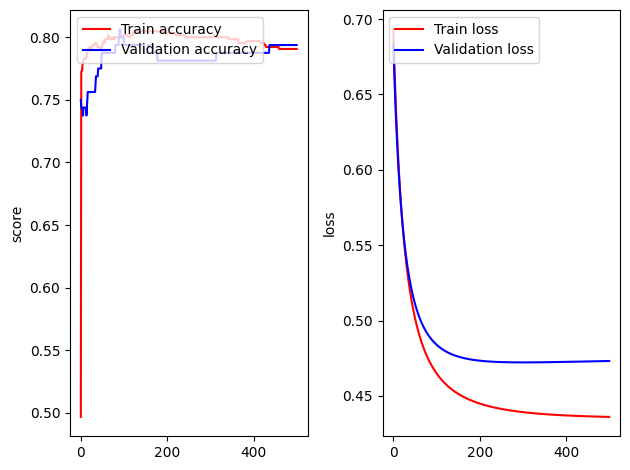

In [510]:
def plot(runner):
    plt.figure()
    plt.subplot(1, 2, 1)
    epochs = [i for i in range(len(runner.train_scores))]
    plt.plot(epochs, runner.train_scores, color='r', label="Train accuracy")
    plt.plot(epochs, runner.val_scores, color='b', label="Validation accuracy")
    plt.ylabel("score")
    plt.legend(loc="upper left")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, runner.train_loss, color='r', label="Train loss")
    plt.plot(epochs, runner.val_loss, color='b', label="Validation loss")
    plt.ylabel("loss")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

plot(runner)

In [511]:
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.8050/0.4147


## 3.2 基于Softmax回归的多分类任务

In [512]:
def make_multiclass_classification(n_samples=100, n_features=2, n_classes=3, shuffle=True, noise=0.1):
    n_sample_per_class = [int(n_samples / n_classes) for k in range(n_classes)]
    for i in range(n_samples - sum(n_sample_per_class)):
        n_sample_per_class[i % n_classes] += 1
    
    X = torch.zeros([n_samples, n_features])
    y = torch.zeros([n_samples], dtype=torch.int64)

    # 随机生成3个簇中心作为类别中心
    centroids = torch.randperm(2 ** n_features)[:n_classes]
    # print(centroids[:5])
    # print(centroids.numpy()[:5])
    centroids_bin = np.unpackbits(centroids.numpy().astype('uint8')).reshape([-1, 8])[:, -n_features:]
    # print(centroids_bin[:5, :])
    """ np.unpackbits
    [[ 2] [ 7] [23]] => [[0 0 0 0 0 0 1 0] [0 0 0 0 0 1 1 1] [0 0 0 1 0 1 1 1]]
    """
    centroids = torch.tensor(centroids_bin, dtype=torch.float32)
    # print(centroids[:5, :])
    print(centroids.shape)
    X[:, :n_features] = torch.randn([n_samples, n_features])

    stop = 0
    for k, centroid in enumerate(centroids):
        start, stop = stop, stop + n_sample_per_class[k]
        y[start:stop] = k
        X_k = X[start:stop, :n_features]
        # 控制每个类别特征值的分散程度
        A = 2 * torch.rand([n_features, n_features]) - 1
        X_k[...] = torch.matmul(X_k, A)
        X_k += centroid
        X[start:stop, :n_features] = X_k

    if noise is not None or noise > 0.:
        noise_mask = torch.rand([n_samples]) < noise
        for i in range(len(noise_mask)):
            if noise_mask[i]:
                y[i] = torch.randint(n_classes, size=[1])
    
    if shuffle:
        idx = torch.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
    
    return X, y

torch.Size([3, 2])
torch.Size([1000, 2])


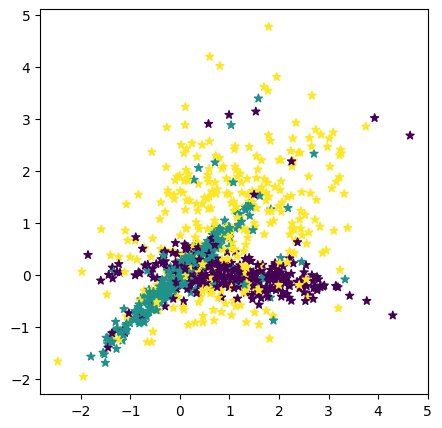

In [513]:
torch.seed = 102
n_samples = 1000
X, y = make_multiclass_classification(n_samples=n_samples, n_features=2, n_classes=3, noise=0.2)
print(X.shape)
plt.figure(figsize=(5, 5))
plt.scatter(x=X[:, 0].tolist(), y=X[:, 1].tolist(), c=y.tolist(), marker='*')
plt.show()

In [514]:
num_train = 640
num_val = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_val, y_val = X[num_train:num_train + num_val], y[num_train:num_train + num_val]
X_test, y_test = X[num_train + num_val:], y[num_train + num_val:]

X_train.shape, y_train.shape, y_train[:5]
X_val.shape, y_val.shape

(torch.Size([160, 2]), torch.Size([160]))

$${\rm{softmax}}(x_k)=\frac{\exp{(x_k)}}{\sum_{i=1}^{K}\exp{(x_i)}}$$

In [515]:
def softmax(X):
    """ 
    input:
        X: shape[N, D]
    """
    max_X, index = torch.max(X, dim=1, keepdim=True)
    # print(max_X, index)
    X_exp = torch.exp(X - max_X) # 解决溢出问题
    
    partition = torch.sum(X_exp, dim=1, keepdim=True)
    return X_exp / partition

X = torch.tensor([[0.1, 0.2, 0.3, 0.4]])
predict = softmax(X)
print(predict)

tensor([[0.2138, 0.2363, 0.2612, 0.2887]])


In [516]:
class Model_SR(Op):
    def __init__(self, feature_size, output_size):
        super(Model_SR, self).__init__()

        self.feature_size = feature_size
        self.output_size = output_size
        self.params = {}
        self.params['W'] = torch.zeros(size=[feature_size, output_size])
        self.params['b'] = torch.zeros(size=[output_size])
        self.grads = {}
        self.X = None
        self.outputs = None
    
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        self.X = X
        # print(X.shape, self.params['W'].shape, self.params['b'].shape)
        score = torch.matmul(X, self.params['W']) + self.params['b']
        # print(score)
        self.outputs = softmax(score)
        return self.outputs
    
    def backward(self, labels): 
        N = labels.shape[0]
        labels = torch.nn.functional.one_hot(labels, num_classes=self.output_size)
        # print("X.shape:", self.X.shape)
        # print("labels.shape:", labels.shape)
        # print("outputs.shape:", outputs.shape)
        self.grads['W'] = -1. / N * torch.matmul(self.X.t(), labels - self.outputs) 
        # print("grads['W'].shape:", self.grads['W'].shape)
        self.grads['b'] = -1. / N * torch.matmul(torch.ones(size=[N]), labels - self.outputs)
        # print("grads['b'].shape:", self.grads['b'].shape)

inputs = torch.randn([1, 4])
model = Model_SR(feature_size=inputs.shape[1], output_size = 3)
outputs = model(inputs)
print("Output is:", outputs)

Output is: tensor([[0.3333, 0.3333, 0.3333]])


In [517]:
class MultiCrossEntropyLoss(Op):
    def __init__(self):
        self.predicts = None
        self.labels = None
        self.num = None

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)
    
    def forward(self, predicts, labels):
        self.predicts = predicts # shape=[N,C]
        self.labels = labels # shape=[N]
        self.num = predicts.shape[0]
        loss = 0.
        for i in range(self.num):
            index = labels[i]
            loss -= torch.log(predicts[i][index])
        
        return loss / self.num

labels = torch.tensor([0], dtype=torch.int32)
mce_loss = MultiCrossEntropyLoss()
mce_loss(outputs, labels)

tensor(1.0986)

best accuracy performance has been updated:  0.00000 -->  0.48750
[Train] epoch: 0, loss: 1.0986149311065674, score: 0.328125
[Validation] epoch: 0, loss: 1.0880300998687744, score: 0.48750001192092896
best accuracy performance has been updated:  0.48750 -->  0.50625
best accuracy performance has been updated:  0.50625 -->  0.51875
best accuracy performance has been updated:  0.51875 -->  0.53125
best accuracy performance has been updated:  0.53125 -->  0.53750
best accuracy performance has been updated:  0.53750 -->  0.54375
best accuracy performance has been updated:  0.54375 -->  0.55000
best accuracy performance has been updated:  0.55000 -->  0.55625
best accuracy performance has been updated:  0.55625 -->  0.56250
best accuracy performance has been updated:  0.56250 -->  0.56875
best accuracy performance has been updated:  0.56875 -->  0.57500
best accuracy performance has been updated:  0.57500 -->  0.58125
best accuracy performance has been updated:  0.58125 -->  0.58750
[Train

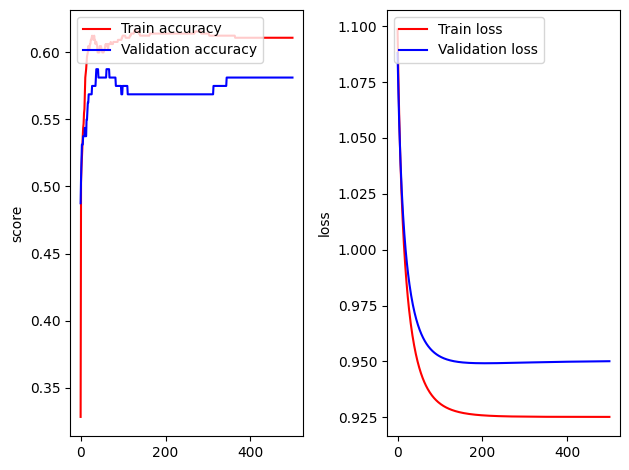

In [518]:
feature_size = 2
output_size = 3
model = Model_SR(feature_size=feature_size, output_size=output_size)
optimizer = SimpleBatchGD(init_lr=0.1, model=model)
loss_fn = MultiCrossEntropyLoss()
metric = accuracy
runner = RunnerV2(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)
runner.train(train_dataset=[X_train, y_train], val_dataset=[X_val, y_val], num_epochs=500, log_epoch=50, save_path="./checkpoint_SR/")

plot(runner)

In [519]:
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.6300/0.9055


## 3.3 鸢尾花分类任务

X.shape: torch.Size([150, 4])
y.shape: torch.Size([150])
tensor([1, 0, 1, 1, 1])
best accuracy performance has been updated:  0.00000 -->  0.26667
[Train] epoch: 0, loss: 1.09861159324646, score: 0.3166666626930237
[Validation] epoch: 0, loss: 1.086010456085205, score: 0.2666666805744171
best accuracy performance has been updated:  0.26667 -->  0.33333
best accuracy performance has been updated:  0.33333 -->  0.40000
best accuracy performance has been updated:  0.40000 -->  0.46667
best accuracy performance has been updated:  0.46667 -->  0.53333
best accuracy performance has been updated:  0.53333 -->  0.60000
[Train] epoch: 10, loss: 0.9850260615348816, score: 0.6333333253860474
[Validation] epoch: 10, loss: 0.9961513876914978, score: 0.6000000238418579
[Train] epoch: 20, loss: 0.9099079966545105, score: 0.6666666865348816
[Validation] epoch: 20, loss: 0.925975501537323, score: 0.6000000238418579
[Train] epoch: 30, loss: 0.8491678237915039, score: 0.6666666865348816
[Validation] epoc

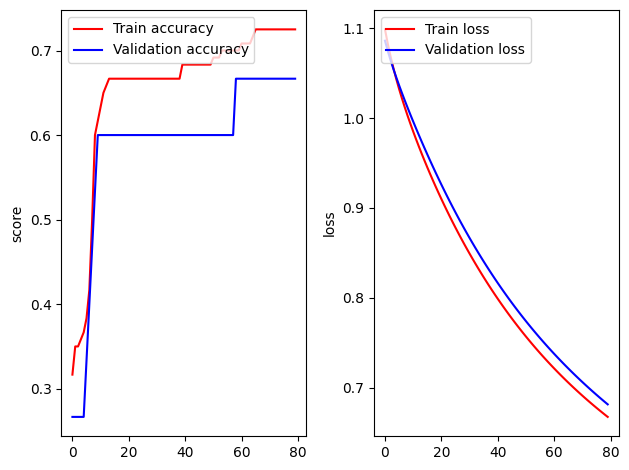

In [520]:
def load_iris_data(shuffle=True):
    data = pd.read_csv("./dataset/Iris.csv")

    y = data["Species"].values
    y[y == 'Iris-setosa'] = 0
    y[y == 'Iris-versicolor'] = 1
    y[y == 'Iris-virginica'] = 2
    X = data.drop(["Id", "Species"], axis=1).values
    X = torch.tensor(X.tolist(), dtype=torch.float32)
    y = torch.tensor(y.tolist())
    print("X.shape:", X.shape)
    print("y.shape:", y.shape)

    X_max, index = torch.max(X, dim=0)
    X_min, index = torch.min(X, dim=0)
    X = (X - X_min) / (X_max - X_min)

    if shuffle:
        idx = torch.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
    return X, y

torch.seed = 102
num_train = 120
num_val = 15
num_test = 15
X, y = load_iris_data()
X_train, y_train = X[:num_train], y[:num_train]
X_val, y_val = X[num_train:num_train + num_val], y[num_train:num_train + num_val]
X_test, y_test = X[num_train + num_val:], y[num_train + num_val:]
print(y_train[:5])

feature_size = 4
output_size = 3
model = Model_SR(feature_size=feature_size, output_size=output_size)
optimizer = SimpleBatchGD(init_lr=0.2, model=model)
metric = accuracy
loss_fn = MultiCrossEntropyLoss()
runner = RunnerV2(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)
runner.train(train_dataset=[X_train, y_train], val_dataset=[X_val, y_val], num_epochs=80, log_epochs=10, save_path='./checkpoint_Iris')

plot(runner)

In [521]:
runner.load_model("./checkpoint_Iris/params.pt")
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.8667/0.6854


In [523]:
X, label = torch.unsqueeze(X_test[0], dim=0), torch.unsqueeze(y_test[0], dim=0)
print("X_test[0] y_test[0]:", X_test[0], y_test[0])
predicts = runner.predict(X)
pred = torch.argmax(predicts).numpy()
print("label:", label, "prediction:", pred)

X_test[0] y_test[0]: tensor([0.2222, 0.7500, 0.1017, 0.0417]) tensor(0)
label: tensor([0]) prediction: 0
